In [2]:
!pip install medmnist

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 8.3 MB/s 
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116949 sha256=f2c1adad59f393d97d6777af172eff941582664e1efc73270c62ce3f5c50bb3b
  Stored in directory: /root/.cache/pip/wheels/5b/eb/43/7295e71293b218ddfd627f935229bf54af9018add7fbb5aac6
Successfully built fire


In [3]:
from fastai.vision.all import *
from fastai import *
import numpy as np
import pandas as pd
import os
import torch
import matplotlib.pyplot as plt
import medmnist
from medmnist import INFO, Evaluator
import torchvision.transforms as transforms
from fastai.data.external import *

In [4]:
data_flag = 'octmnist'
download = True
info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

In [5]:
DataClass=getattr(medmnist, info['python_class'])

In [6]:
train_dataset= DataClass(split='train',download=download)
val_dataset=DataClass(split='val',download=download)
test_dataset=DataClass(split='test',download=download)

  0%|          | 0/54938180 [00:00<?, ?it/s]

Using downloaded and verified file: /root/.medmnist/octmnist.npz
Using downloaded and verified file: /root/.medmnist/octmnist.npz


In [7]:
data={'Image':[],"Labels":[],"is_valid":[]}

In [8]:
for i in range(len(train_dataset)):
  data['Image'].append(train_dataset[i][0])
  data['Labels'].append(train_dataset[i][1][0])
  data['is_valid'].append(True)

for i in range(len(val_dataset)):
  data['Image'].append(val_dataset[i][0])
  data['Labels'].append(val_dataset[i][1][0])
  data['is_valid'].append(False)

In [9]:
train_df=pd.DataFrame.from_dict(data)
train_df

,Image,Labels,is_valid
0,<PIL.Image.Image image mode=L size=28x28>,0,True
1,<PIL.Image.Image image mode=L size=28x28>,3,True
2,<PIL.Image.Image image mode=L size=28x28>,3,True
3,<PIL.Image.Image image mode=L size=28x28>,3,True
4,<PIL.Image.Image image mode=L size=28x28>,0,True
...,...,...,...
108304,<PIL.Image.Image image mode=L size=28x28>,0,False
108305,<PIL.Image.Image image mode=L size=28x28>,3,False
108306,<PIL.Image.Image image mode=L size=28x28>,0,False
108307,<PIL.Image.Image image mode=L size=28x28>,0,False


In [10]:
train_df=train_df.sample(frac = 1).reset_index(drop=True)
train_df

,Image,Labels,is_valid
0,<PIL.Image.Image image mode=L size=28x28>,3,True
1,<PIL.Image.Image image mode=L size=28x28>,0,True
2,<PIL.Image.Image image mode=L size=28x28>,3,True
3,<PIL.Image.Image image mode=L size=28x28>,1,True
4,<PIL.Image.Image image mode=L size=28x28>,3,True
...,...,...,...
108304,<PIL.Image.Image image mode=L size=28x28>,3,True
108305,<PIL.Image.Image image mode=L size=28x28>,3,True
108306,<PIL.Image.Image image mode=L size=28x28>,2,False
108307,<PIL.Image.Image image mode=L size=28x28>,3,True


In [11]:
def get_x(r):
    img=r['Image'].resize((227,227))  
    img=np.asarray(img)
    return (img).astype(np.uint8)

def get_y(r):
    return r["Labels"]

In [12]:
switch=True
block=""
if n_channels==1 and switch:
  block=(ImageBlock(cls=PILImageBW), CategoryBlock) # black & white
else:
  block=(ImageBlock(), CategoryBlock)

dblock = DataBlock(
    blocks=block,
    get_x=get_x,
    get_y=get_y,
    splitter=ColSplitter()
)

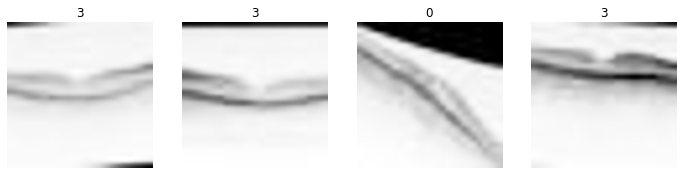

In [13]:
dls = dblock.dataloaders(train_df, bs=32)
dls.show_batch(nrows=1, ncols=4)

In [14]:
learn = vision_learner(dls, vgg16_bn, metrics=accuracy)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [15]:
learn.fine_tune(5, base_lr=3e-3, freeze_epochs=4)  

epoch,train_loss,valid_loss,accuracy,time
0,1.113426,0.770922,0.740400,11:07
1,0.825562,0.660242,0.776881,10:58
2,0.658450,0.555741,0.811340,10:58
3,0.591380,0.501780,0.829683,10:59


epoch,train_loss,valid_loss,accuracy,time


epoch,train_loss,valid_loss,accuracy,time
0,0.449069,0.421436,0.858264,11:46
1,0.333164,0.366854,0.879500,11:47
2,0.253618,0.364978,0.887707,11:47
3,0.090024,0.381797,0.891728,11:46
4,0.030508,0.404819,0.895852,11:48


In [16]:
learn.metrics = accuracy
learn.validate() #(loss,accuracy)(for validation)

(#2) [0.4048192501068115,0.8958523273468018]

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60) # confusion matrix

In [ ]:
interp.most_confused(min_val=5) # prints (actual label,predicted label,freq of misclassified examples) (freq>=min_value)

In [24]:
predictions=[]
labels=[]
for i in range(len(test_dataset)):
  img=np.asarray(test_dataset[i][0].resize((227,227)))
  img=(img).astype(np.uint8)
  pred,_,probs=learn.predict(img)
  predictions.append(int(pred))
  labels.append(test_dataset[i][1][0])

In [25]:
from sklearn.metrics import classification_report
print(classification_report(labels, predictions))

              precision    recall  f1-score   support

           0       0.62      0.96      0.75       250
           1       0.96      0.78      0.86       250
           2       0.91      0.23      0.37       250
           3       0.70      0.96      0.81       250

    accuracy                           0.73      1000
   macro avg       0.80      0.73      0.70      1000
weighted avg       0.80      0.73      0.70      1000



In [ ]:
# resnet18, resnet34, resnet50, resnet101, resnet152
# vgg16_bn, vgg19_bn
# alexnet
# densenet121, densenet169, densenet201, densenet161
# squeezenet1_0, squeezenet1_1

## list of models

In [ ]:
#learner.export(export.pkl)
#learner = load_learner(path=learn.path) #store model

In [ ]:
#learn.lr_find() # to find optimal lr